# ROP analysis

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import cantera as ct

print(f"Running Cantera version: {ct.__version__}")

Running Cantera version: 2.6.0


In [2]:
model_path = "/home/alon/Dropbox (MIT)/scripts/DRGScripts/Cantera/ROP/N2H4.yaml"
gas = ct.Solution(model_path)

In [3]:
T = 1000
P = 1e5
tau = 0.0015

time_range_to_plot = [0.0012, 0.0017]

top_ROPs_to_plot = 10

gas.TPX = T, P, {"H4N2(1)": 1.0}

ROP_species = ['H4N2(1)', 'H2(3)', 'NH2(4)', 'H3N2(5)', 'ammonia(6)', 'H(9)']

In [4]:
rxn_equations = [r.equation for r in gas.reactions()]
for rxn in gas.reactions():
    if rxn_equations.count(rxn.equation) > 1:
        rxn.duplicate = True

In [5]:
reactor = ct.IdealGasConstPressureReactor(gas, energy="on")
reactor_network = ct.ReactorNet([reactor])
reactor_network.atol = 1e-12
reactor_network.rtol = 1e-12

In [6]:
stoichiometry = {spc.name: list() for spc in gas.species()}
for i, rxn in enumerate(gas.reactions()):
    for spc in gas.species():
        nu = rxn.products.get(spc.name, 0) - rxn.reactants.get(spc.name, 0)
        stoichiometry[spc.name].append(nu)

In [7]:
profiles = {'times': [],
            'Ps': [],
            'Ts': [],
            'Xs': [],
           }
ROPs = {spc.name: dict() for spc in gas.species()}
net_ROP = {spc.name: list() for spc in gas.species()}

time = 0
step, last_step = 0, -1
while time < tau:
    profiles['times'].append(time)
    profiles['Ps'].append(gas.P)
    profiles['Ts'].append(gas.T)
    profiles['Xs'].append(gas.X)
    rops = gas.net_rates_of_progress
    for spc in gas.species():
        dups = list()
        last_step -= 1
        for i, rxn in enumerate(gas.reactions()):
            if stoichiometry[spc.name][i]:
                if rxn.equation not in ROPs[spc.name].keys():
                    ROPs[spc.name][rxn.equation] = list()
                if rxn.duplicate and rxn.equation in dups:
                    ROPs[spc.name][rxn.equation][-1] += rops[i] * stoichiometry[spc.name][i]
                else:
                    ROPs[spc.name][rxn.equation].append(rops[i] * stoichiometry[spc.name][i])
                if rxn.duplicate and rxn.equation not in dups:
                    dups.append(rxn.equation)
                if step > last_step:
                    net_ROP[spc.name].append(rops[i] * stoichiometry[spc.name][i])
                    last_step = step
                else:
                    if len(net_ROP[spc.name]) == 0:
                        net_ROP[spc.name] = [rops[i] * stoichiometry[spc.name][i]]
                    else:
                        net_ROP[spc.name][-1] += rops[i] * stoichiometry[spc.name][i]
    time = reactor_network.step()
    step += 1
    if step > 1e5:
        print('Too many steps, breaking!')
        break
print(f'Number of steps: {step}')

Number of steps: 2765


In [18]:
top_ROPs = {key: dict() for key in ROP_species}
for spc in ROP_species:
    max_rop_value_per_rxn = {rxn: max(rops) for rxn, rops in ROPs[spc].items()}
    max_rop_rxns_sorted = [k for k, v in sorted(max_rop_value_per_rxn.items(), key=lambda item: item[1], reverse=True)]
    for i in range(top_ROPs_to_plot):
        if len(max_rop_rxns_sorted) <= i:
            break
        top_ROPs[spc][max_rop_rxns_sorted[i]] = ROPs[spc][max_rop_rxns_sorted[i]]


## ROP Plots

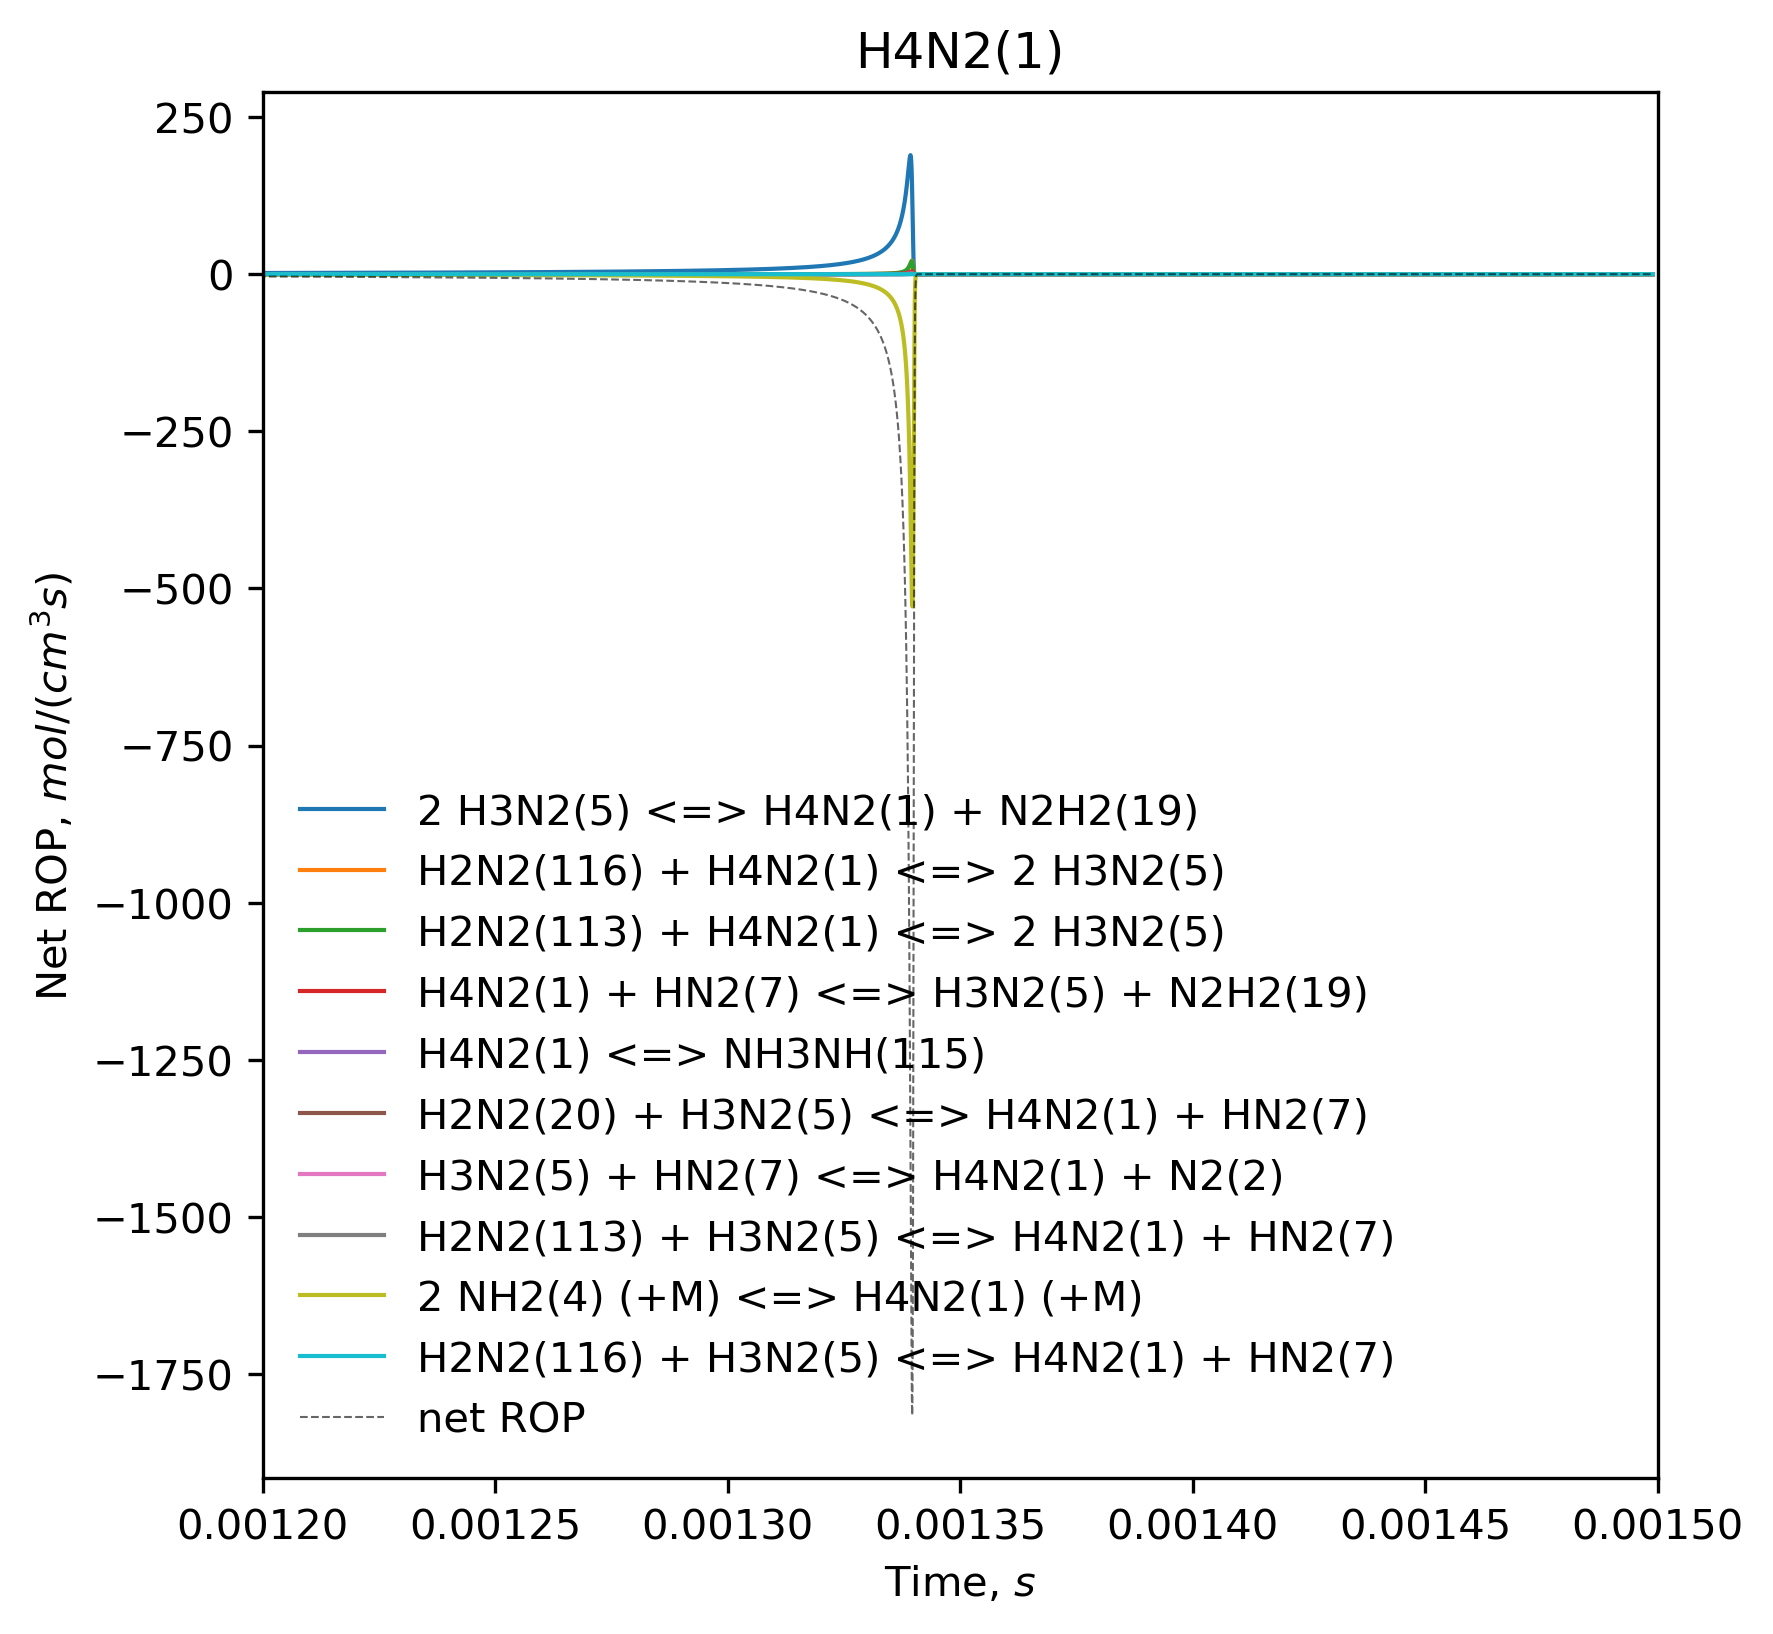

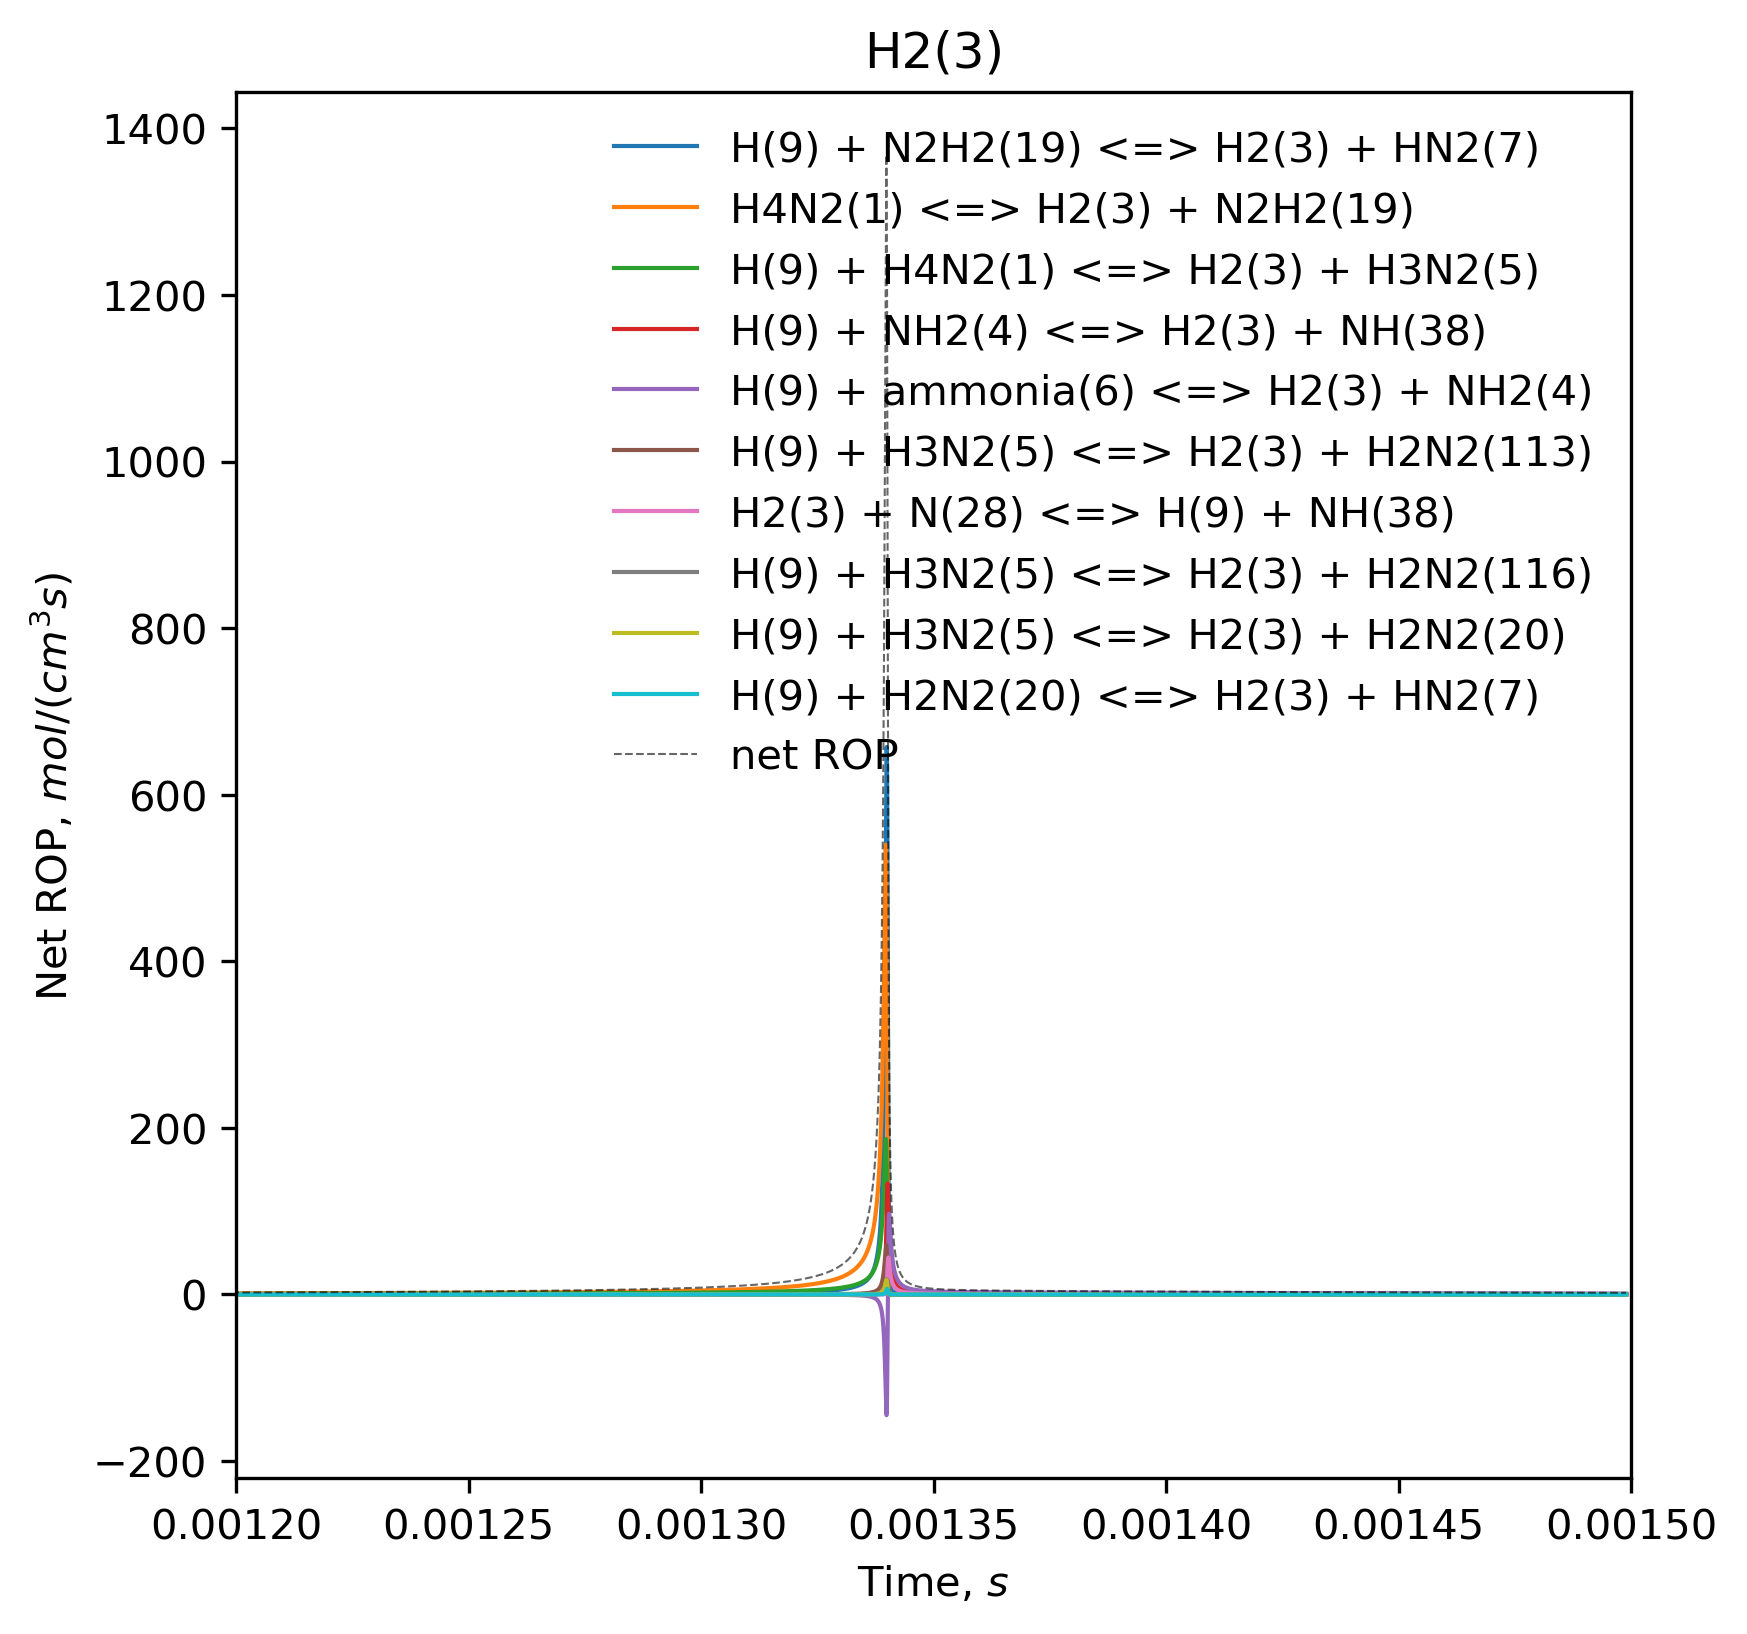

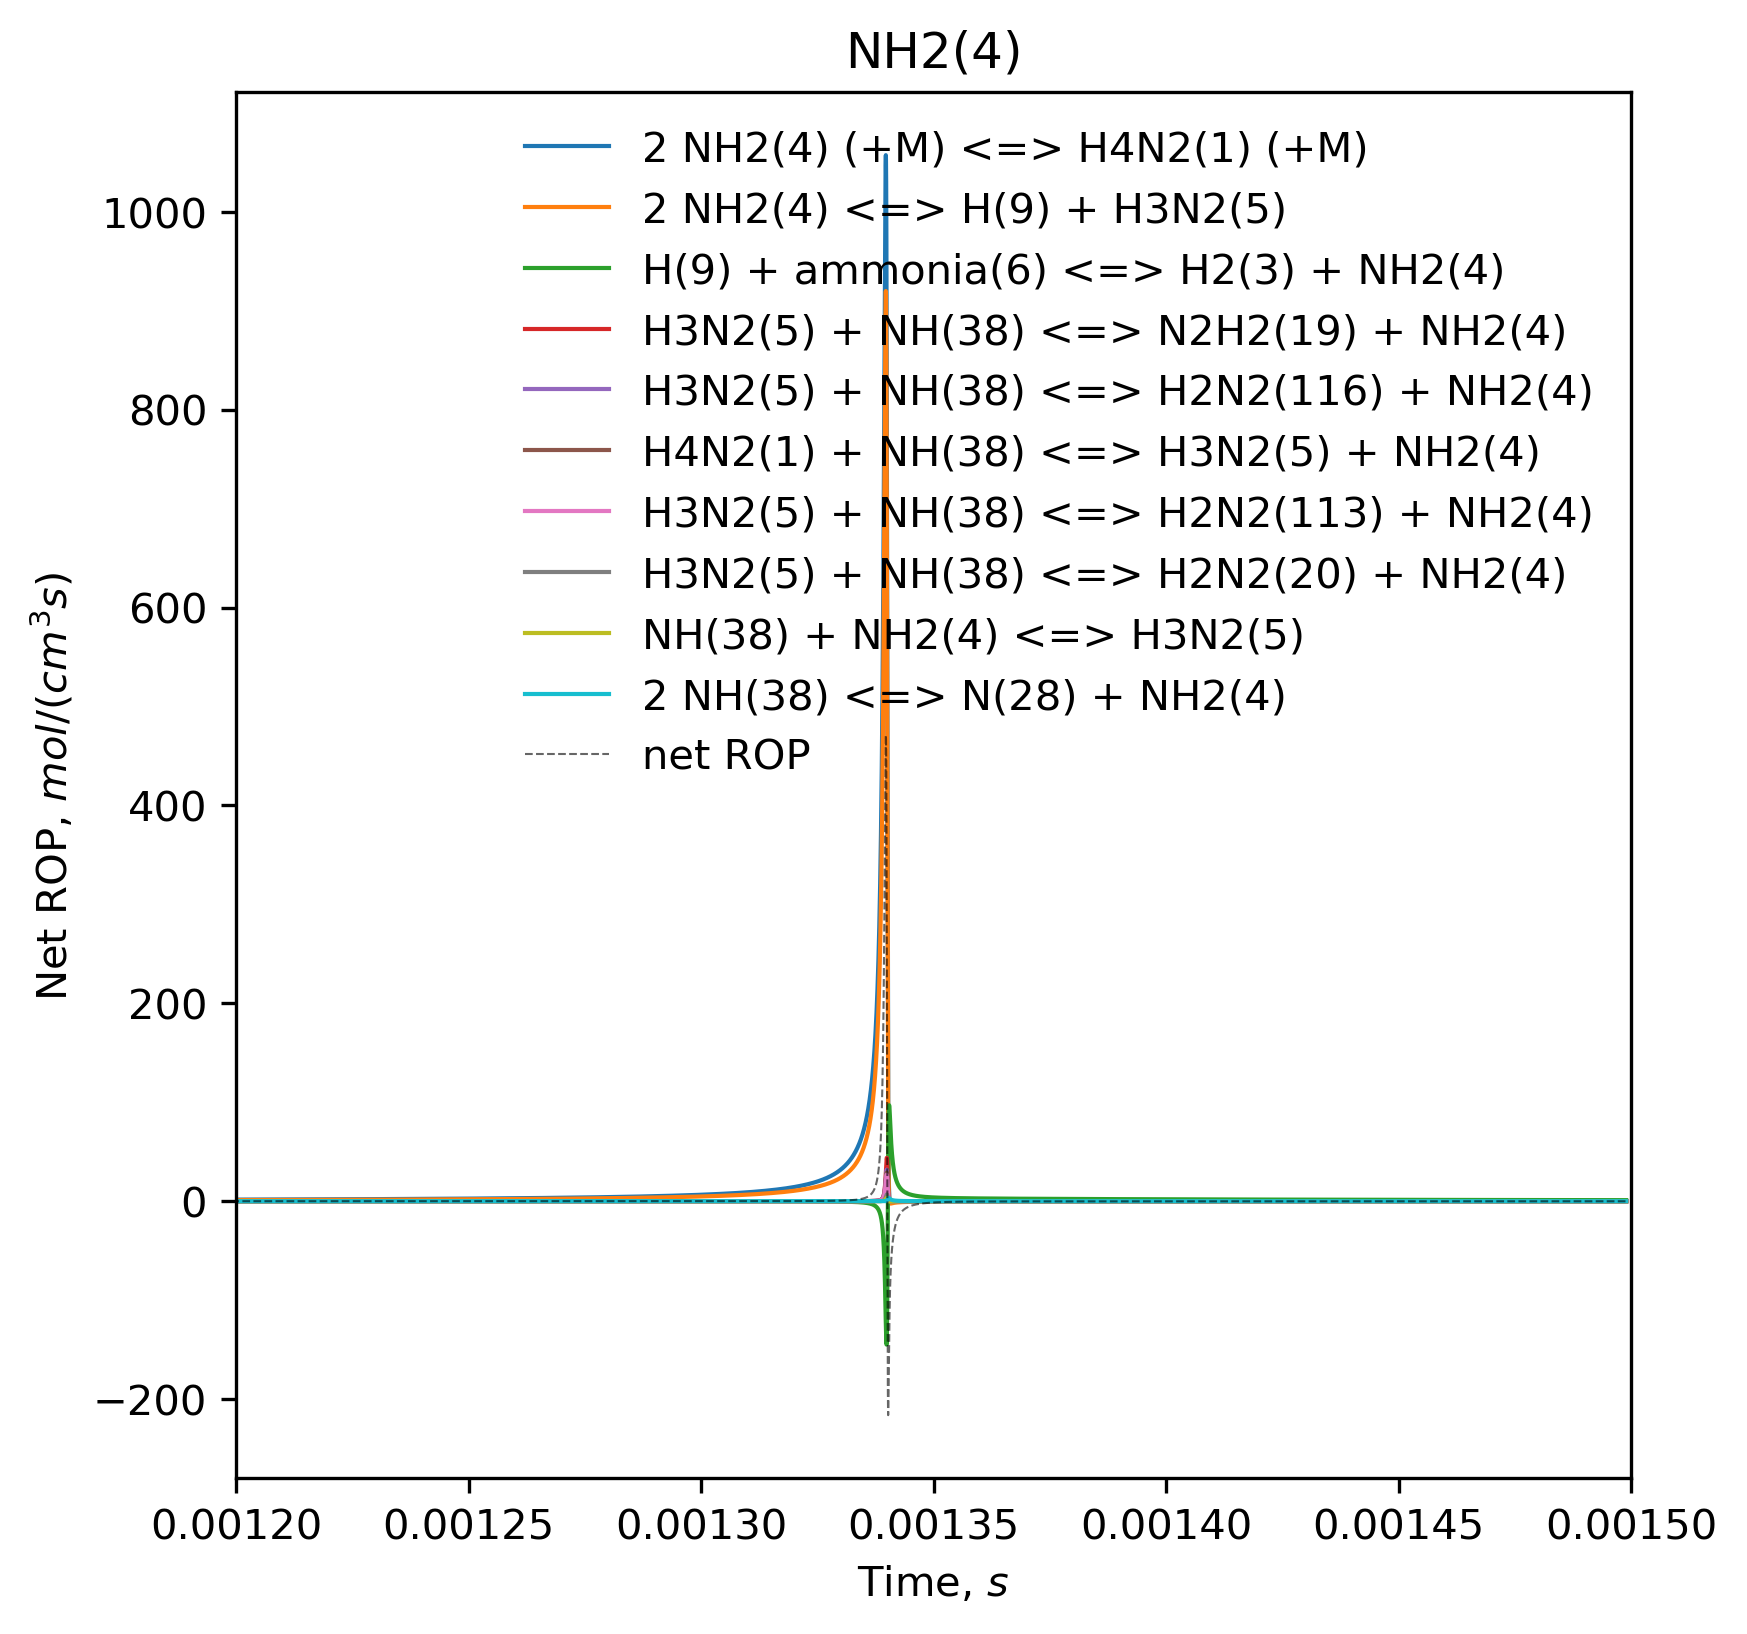

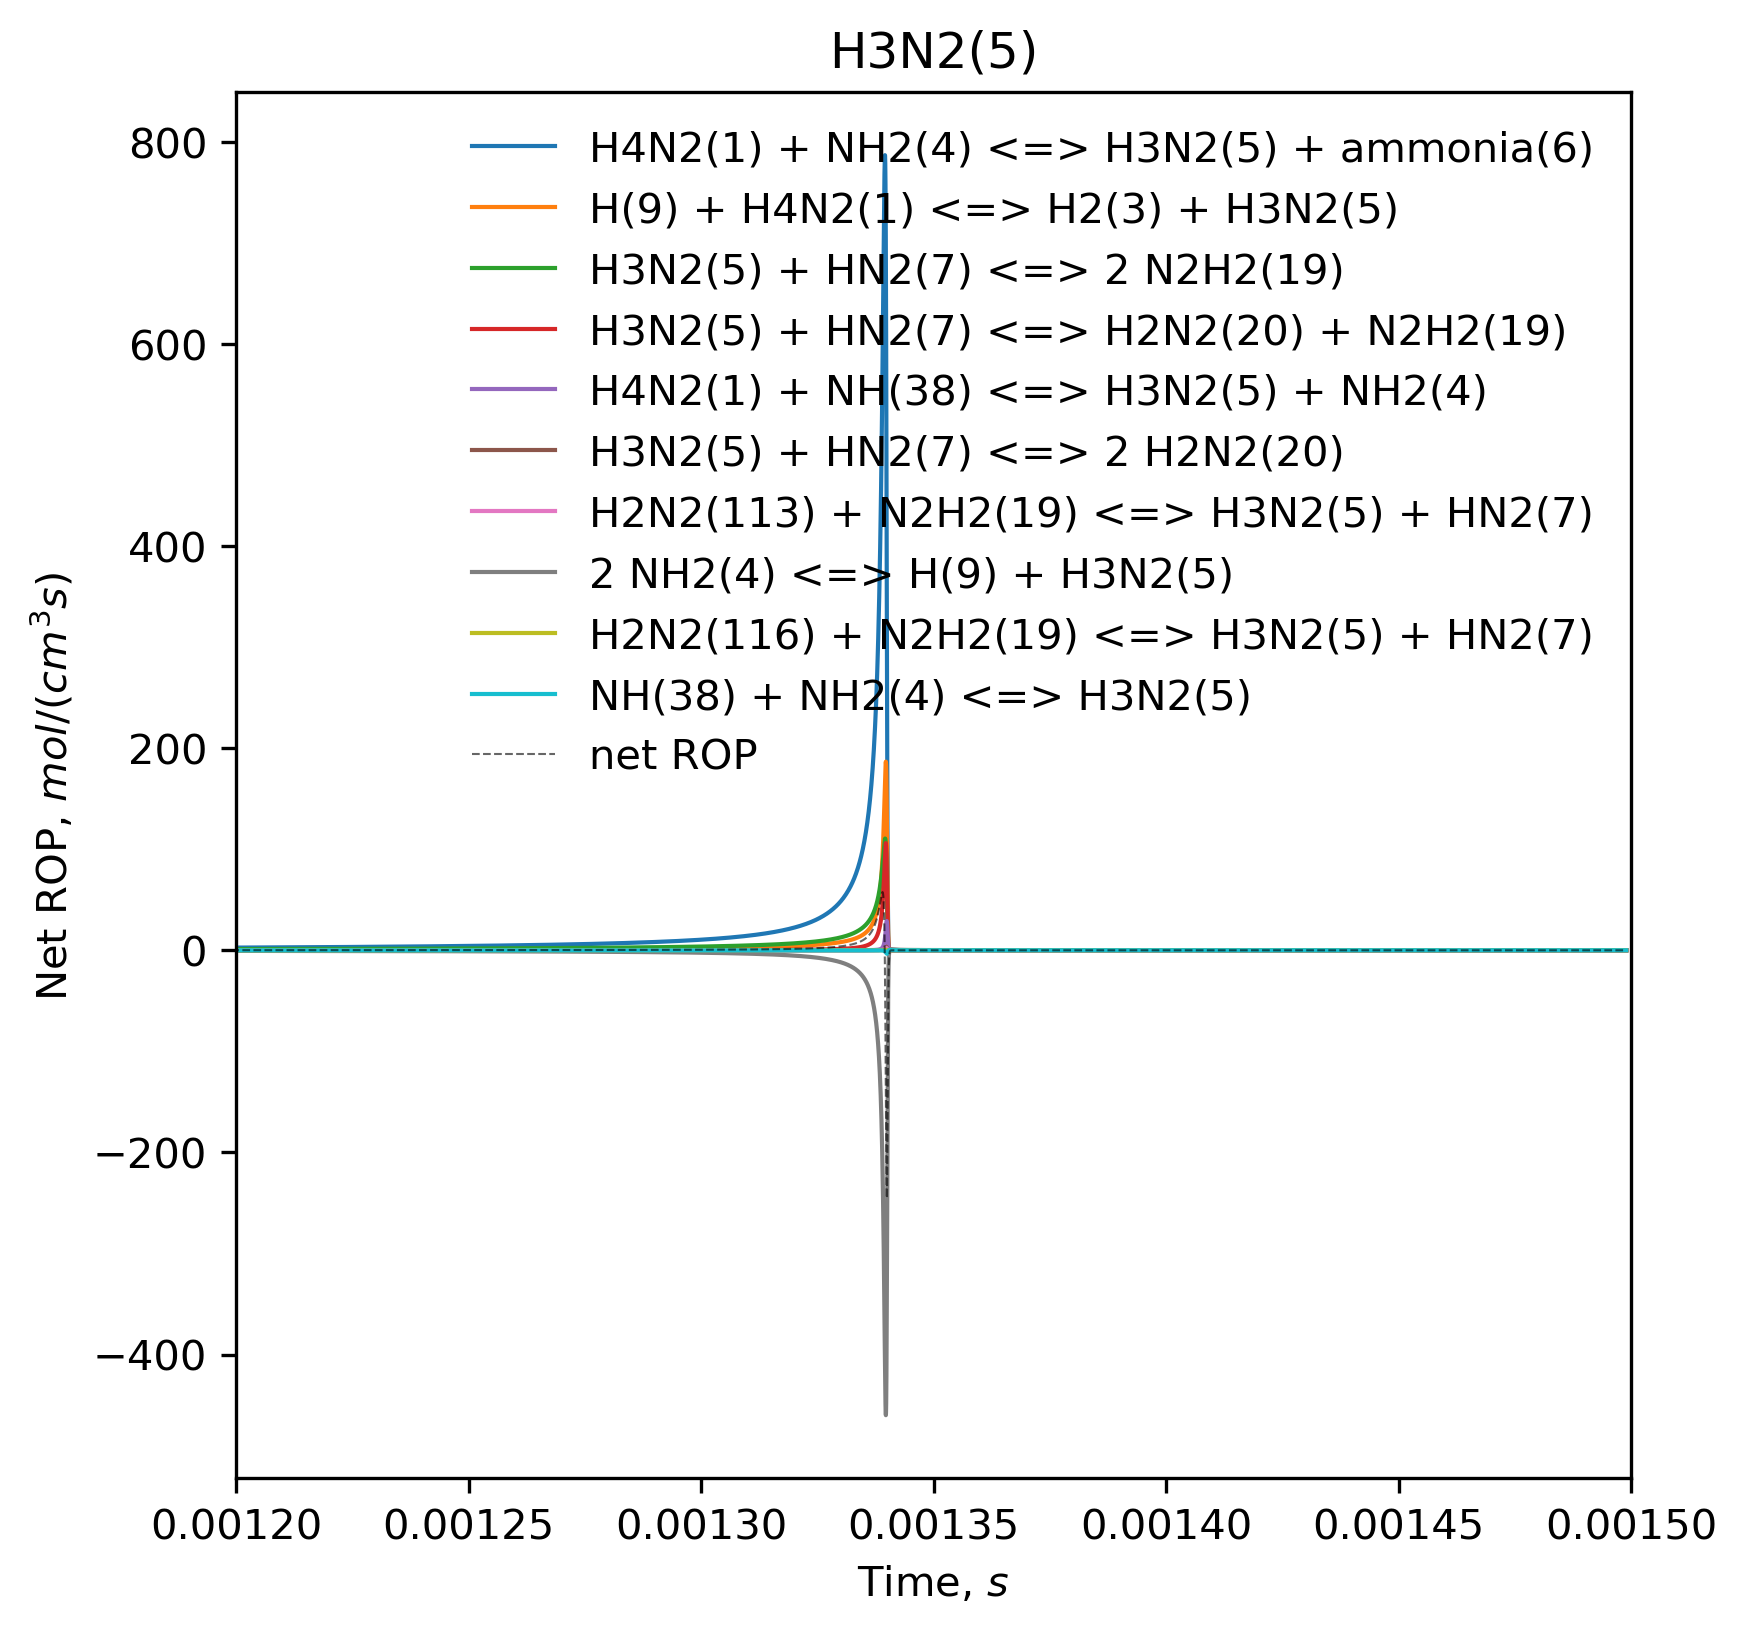

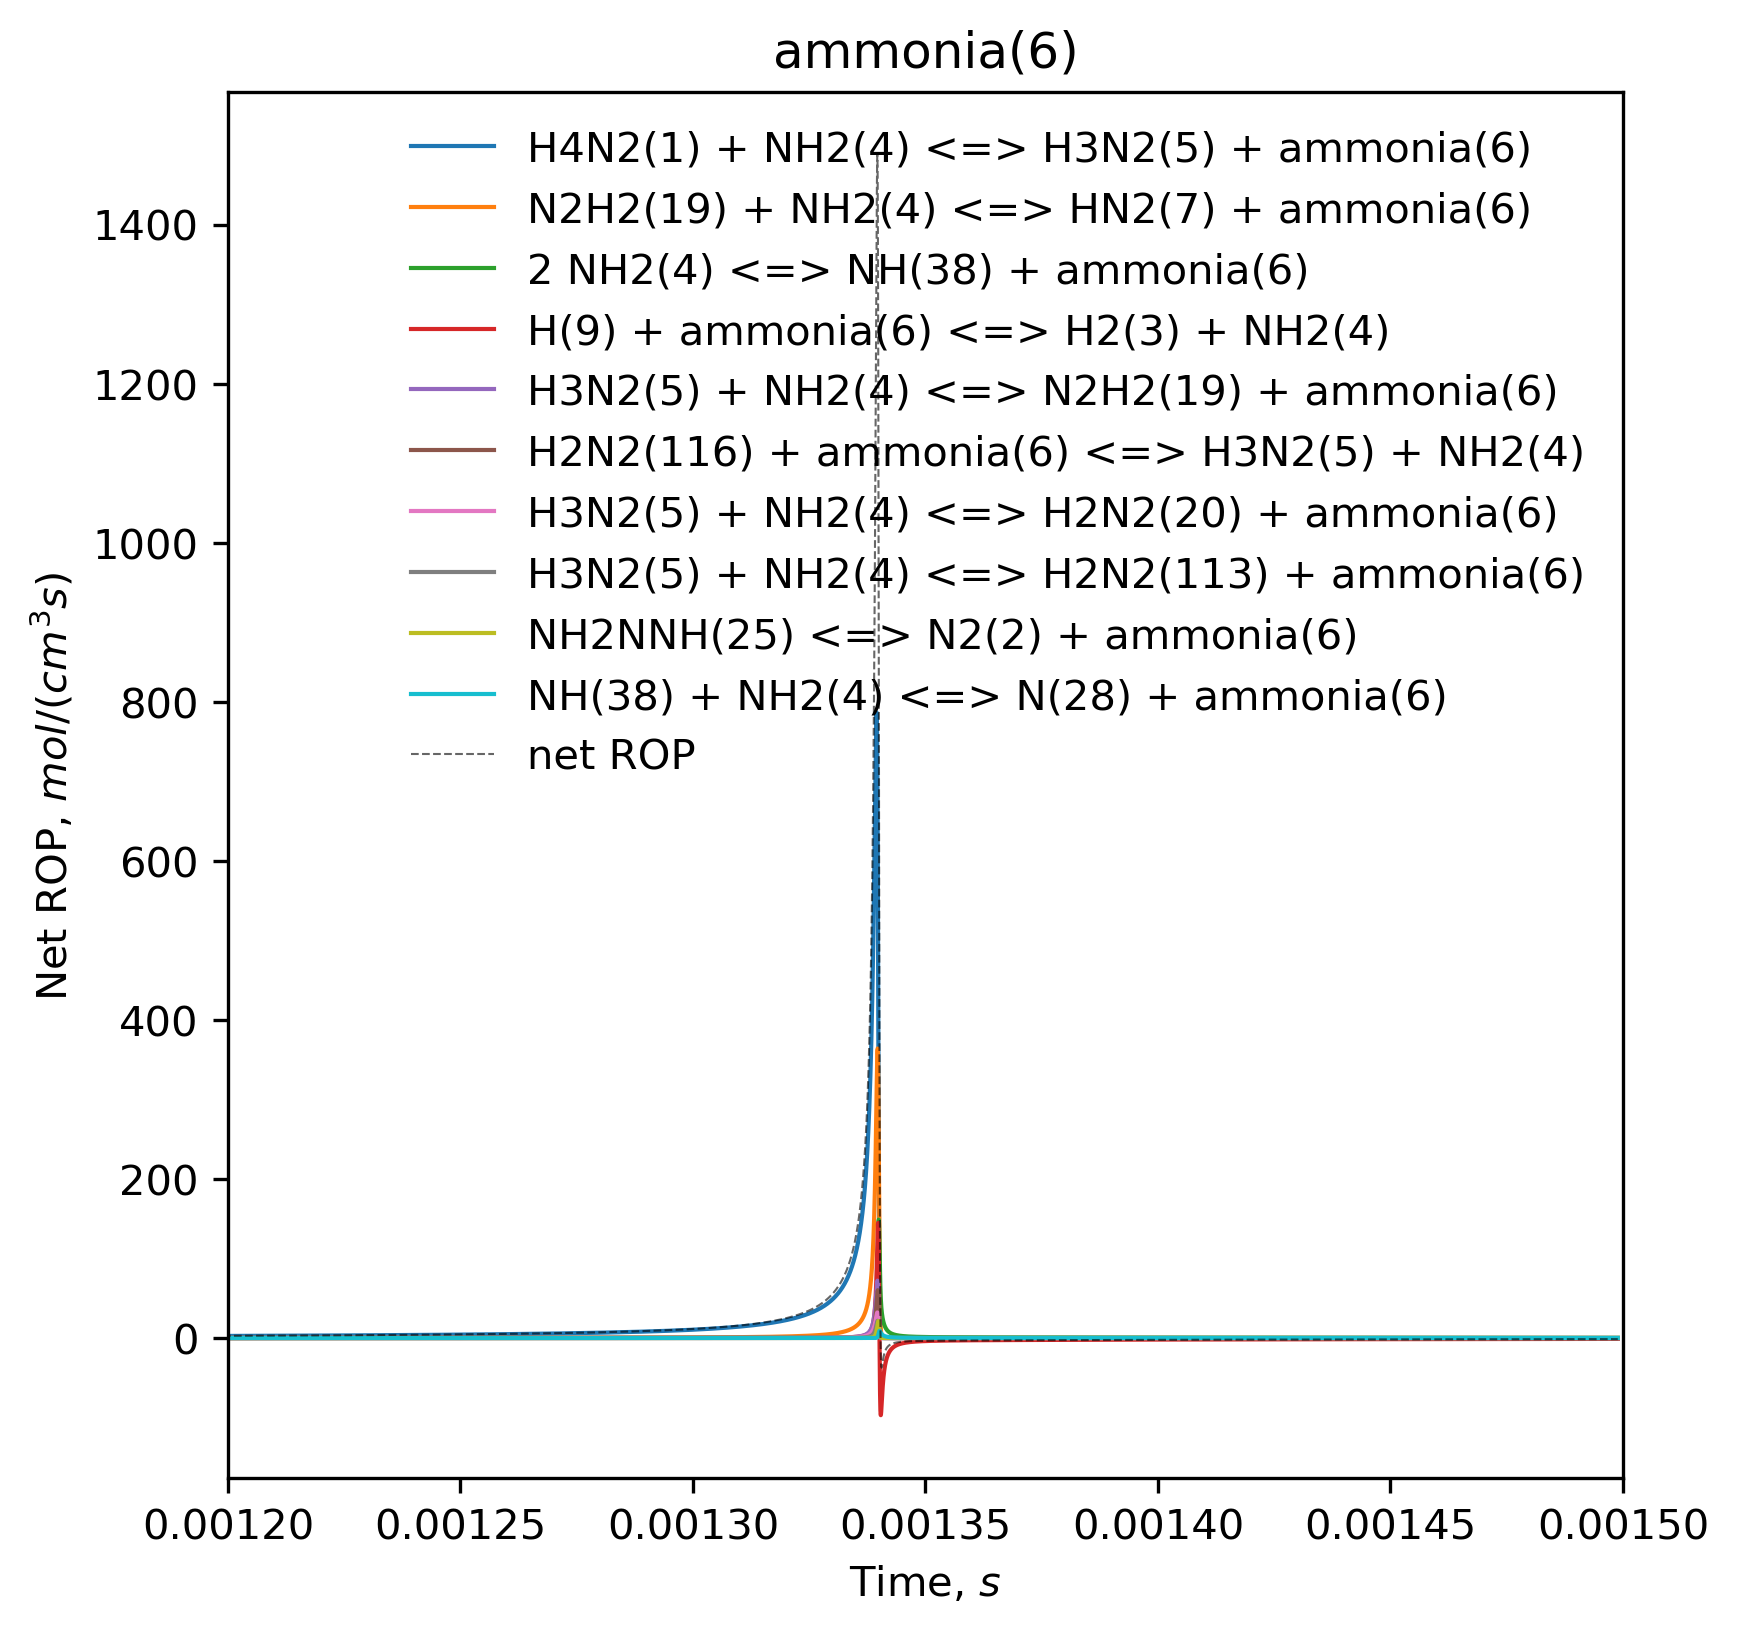

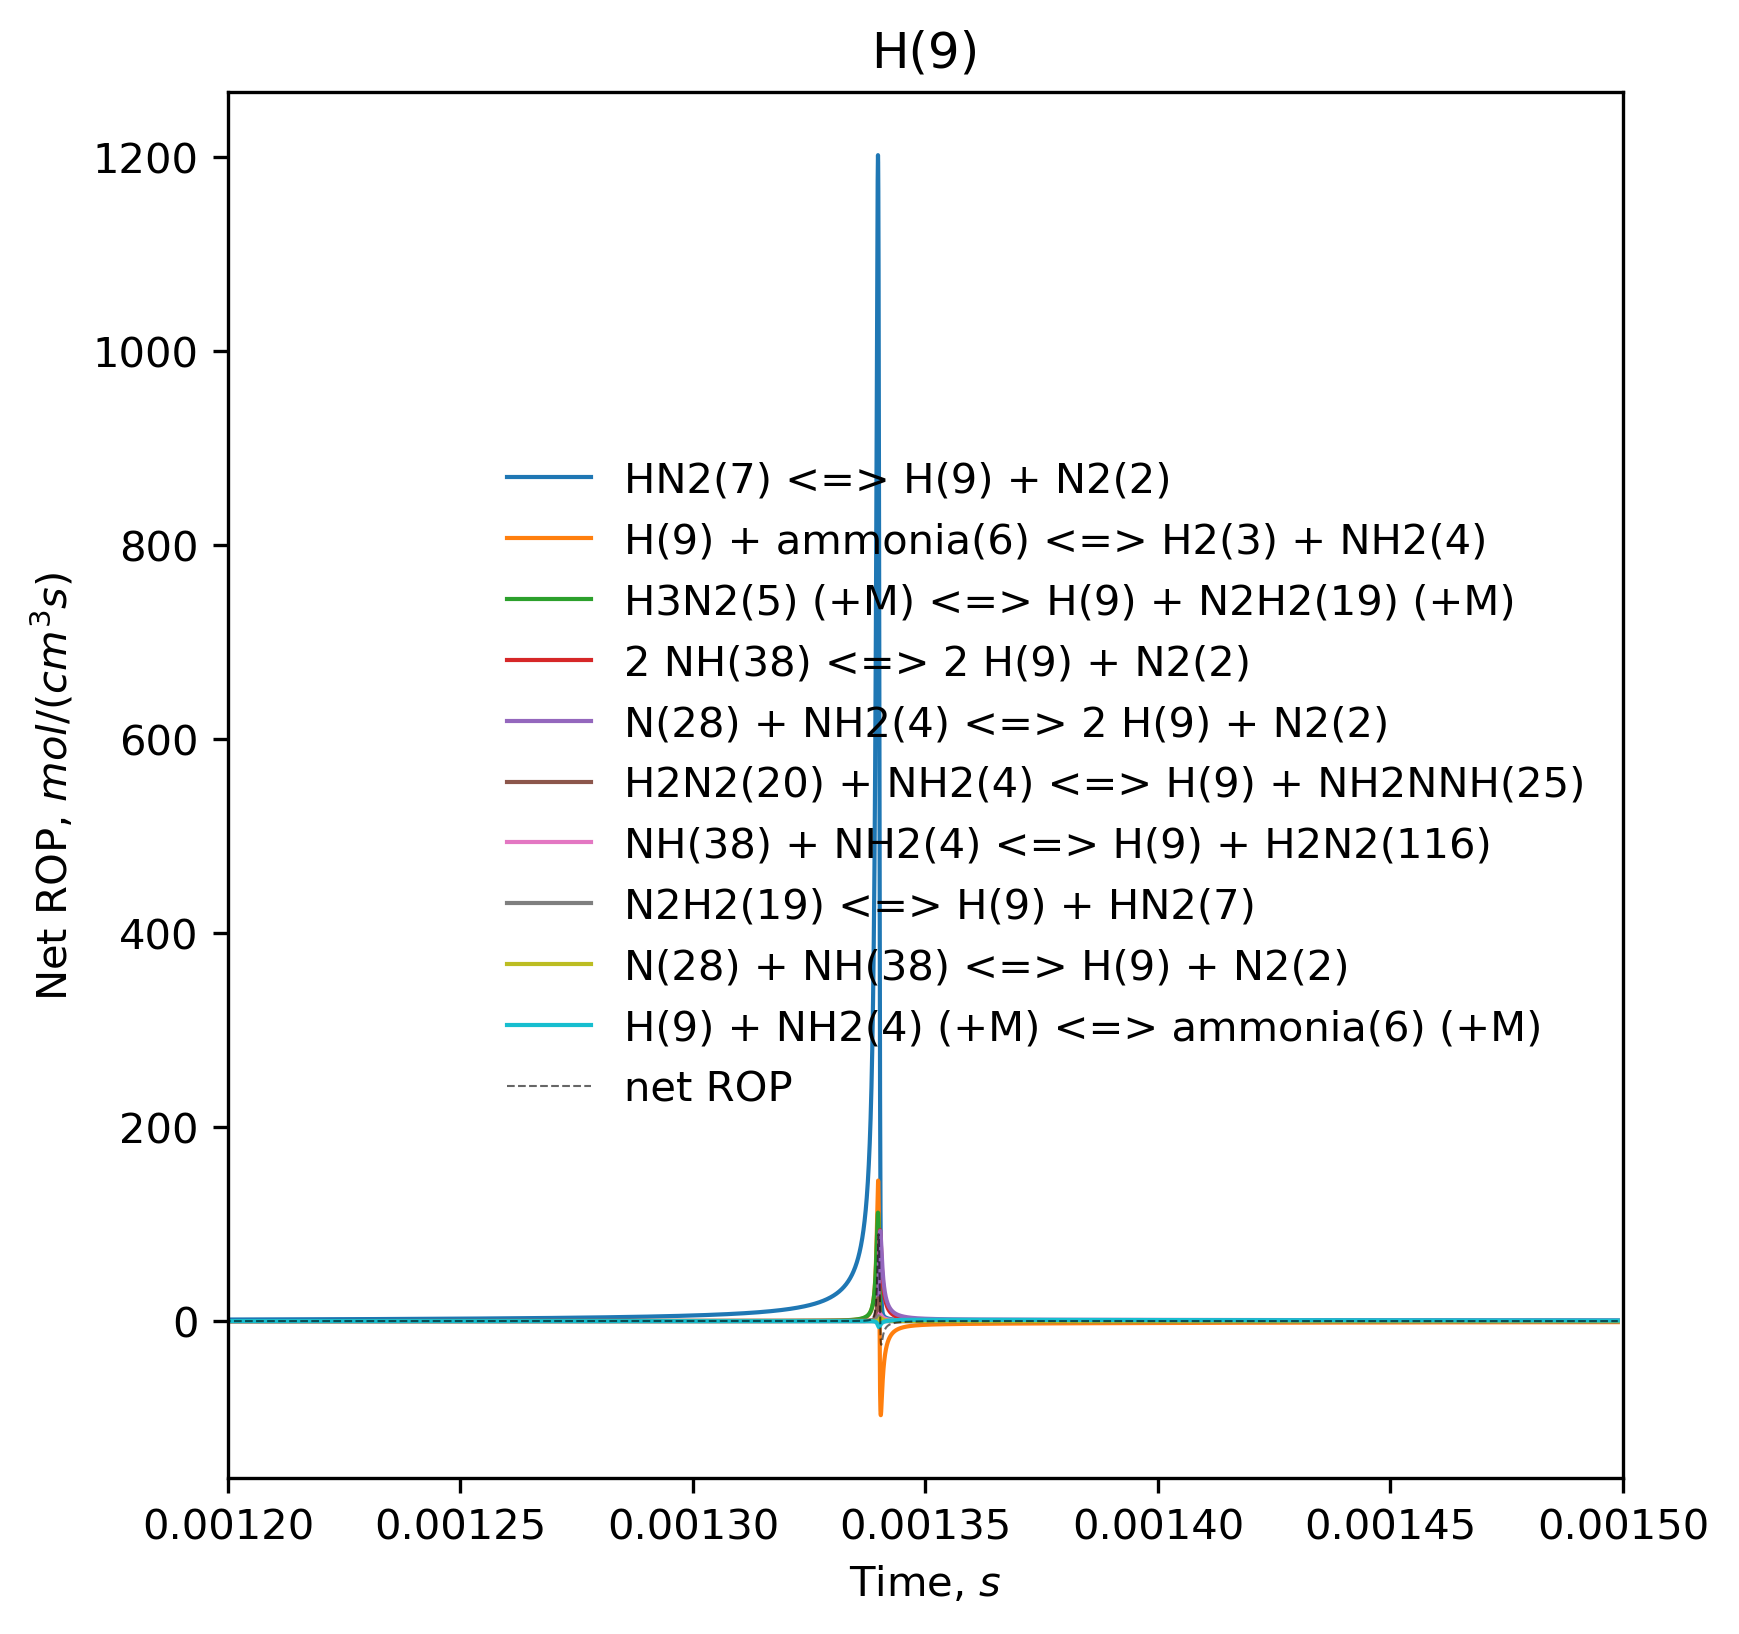

In [19]:
for spc, top_ROP in top_ROPs.items():
    fig = plt.figure(figsize=(6, 6), dpi=300, facecolor='w', edgecolor='k')
    for rxn, rops in top_ROP.items():
        plt.plot(profiles['times'], rops, label=rxn, linewidth=1)
    plt.plot(profiles['times'], net_ROP[spc], 'k--', label='net ROP', linewidth=0.5, alpha=0.6)
    plt.title(spc)
    plt.xlabel(r'Time, $s$')
    plt.ylabel(r'Net ROP, $mol/(cm^3 s)$')
    plt.xlim([0.0012, 0.0015])
    plt.legend(shadow=False, frameon=False)

## Flux diagram

In [20]:
starting_species = 'H4N2(1)'

flux_time = 0.00133  # time at which the flux diagram will be generated, s

explore_tol = 0.95  # capture at least this amount of each species consumption pathway
dead_end_tol = 0.10  # don't explore if comsumption is lower than this tolerance times the net rate of production


In [35]:
def get_closest_index_from_list(value, lst):
    """
    The the ondex of the closest value from a list.
    """
    delta, index = 0, 0
    for i, val in enumerate(lst):
        if i == 0 or abs(value - val) < delta:
            delta = abs(value - val)
            index = i
    return index


def get_opposite_rxn_species(rxn, spc):
    """
    Get the species in a reaction opposite to the given species
    (if the given species is one of the reactants, get the products, and vice versa)
    """
    wells = rxn.split(' <=> ')
    counts = wells[0].count(spc), wells[1].count(spc)
    i = int(counts[0] > counts[1])
    species = wells[i].split(' + ')
    species = [s.strip('(+M)') if '(+M)' in s else s for s in species]
    new_species = list()
    for spc in species:
        max_spc = ''
        spc_splits = spc.split()
        for split in spc_splits:
            if len(split) > len(max_spc):
                max_spc = split
        new_species.append(split.strip())
    return new_species


def should_explore(spc, rxns_rop, dead_end_tol):
    """
    Determine whether we should explore a species (True), or whether it is a dead end (False)
    """
    production, consumption = 0, 0
    for k, v in rxns_rop.items():
        production += v if v > 0 else 0
        consumption += v if v < 0 else 0
    if abs(consumption) < production * dead_end_tol:
        return False
    return True

#print(get_opposite_rxn_species('2 NH2(4) (+M) <=> H4N2(1) (+M)', 'H4N2(1)'))
#print(get_opposite_rxn_species('H3N2(5) + HN2(7) <=> H4N2(1) + N2(2)', 'H4N2(1)'))

In [36]:
index = get_closest_index_from_list(flux_time, profiles['times'])
new_flux_time = profiles['times'][index]
print(f'Using time {new_flux_time} s')

fluxes, n_fluxes = dict(), dict()
max_flux = 0
for spc, rxns_rops in ROPs.items():
    fluxes[spc] = dict()
    for rxn, rops in rxns_rops.items():
        fluxes[spc][rxn] = rops[index]
        if abs(rops[index]) > max_flux:
            max_flux = abs(rops[index])
for spc, rxns_rops in ROPs.items():
    n_fluxes[spc] = dict()
    for rxn, rops in rxns_rops.items():
        n_fluxes[spc][rxn] = rops[index] / max_flux
fluxes = n_fluxes

Using time 0.001330024641863416 s


In [39]:
graph = dict()

stack = [starting_species]
visited = [starting_species]

while len(stack):
    node = stack.pop(-1)
    rxns_rop = fluxes[node]
    rxns_rop_sorted = [(k, v) for k, v in sorted(fluxes[node].items(), key=lambda item: item[1], reverse=False)]
    consumption = 0
    total_consumption = sum([v for k, v in rxns_rop_sorted if v < 0])
    reduces_rxns_rop_sorted = list()
    for k, v in rxns_rop_sorted:
        if v < 0:
            reduces_rxns_rop_sorted.append((k, v))
            consumption += v
            if consumption < total_consumption * explore_tol:
                break
    for rxn_rop in reduces_rxns_rop_sorted:
        rxn, rop = rxn_rop[0], rxn_rop[1]
        opposite_rxn_species = get_opposite_rxn_species(rxn=rxn, spc=node)
        for spc in opposite_rxn_species:
            if spc not in visited:
                if should_explore(spc, rxns_rop, dead_end_tol):
                    stack.append(spc)
                visited.append(spc)
        if node not in graph.keys():
            graph[node] = dict()
        if rxn in graph[node].keys():
            graph[node][rxn][1] += rop
        else:
            graph[node][rxn] = [opposite_rxn_species, rop]
    
    

In [41]:
import pprint

pprint.pprint(graph)

{'H(9)': {'2 NH2(4) <=> H(9) + H3N2(5)': [['NH2(4)'], -0.23391736849913755],
          'H(9) + H4N2(1) <=> H2(3) + H3N2(5)': [['H2(3)', 'H3N2(5)'],
                                                 -0.1595265387914655],
          'H(9) + N2H2(19) <=> H2(3) + HN2(7)': [['H2(3)', 'HN2(7)'],
                                                 -0.11691279322921]},
 'H2(3)': {'H(9) + ammonia(6) <=> H2(3) + NH2(4)': [['H(9)', 'ammonia(6)'],
                                                    -0.008390342831773007]},
 'H2N2(113)': {'H2N2(113) <=> H2N2(20)': [['H2N2(20)'], -0.020293114982269135]},
 'H2N2(116)': {'H2N2(116) <=> N2H2(19)': [['N2H2(19)'], -0.009449581717873424]},
 'H2N2(20)': {'H3N2(5) + HN2(7) <=> H2N2(20) + N2H2(19)': [['H3N2(5)',
                                                            'HN2(7)'],
                                                           -0.027329284368895094]},
 'H3N2(5)': {'2 H3N2(5) <=> H4N2(1) + N2H2(19)': [['H4N2(1)', 'N2H2(19)'],
                         